# in this notebook, we show how to 'freeze' the potential at a given timestep and integrate orbits in the frozen potential. We show how to do a single orbit and a grid of orbits. With the grid of orbits, we make an orbit-area diagram (see e.g. Figure 4 of Petersen et al 2021).

## Note that we assume a PSP file format, but also show examples for SPL file format. The vast majority of the workflow is identical for either file format

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib.colors as colors
import matplotlib
plt.rcParams.update({'font.size': 22})
sys.path.insert(1, '')
sys.path.insert(1, '/home/filion/martinsims')
sys.path.insert(1, '/home/filion/martinsims/exptools/exptool')

from exptool.analysis import commensurability
from exptool.io import psp_io, spl_io,particle
from exptool.utils import utils
from exptool.utils import integrate
from exptool.basis import potential
from exptool.basis import eof
from exptool.utils import *
from exptool.orbits import *
from exptool.observables import visualize
from exptool.analysis import pattern
from exptool.io import outcoef

In [12]:
sim_path = '/usr/data/scylla/rmcclure/cca/sims/Run100/' 
#put the path to the directory where your simulation files live here!

In [3]:
#assuming PSP file format! 
EOF2Dict = eof.read_binary_eof_coefficients_dict(sim_path+'outcoef.star.run2Fb')
#outcoef files should have this general naming scheme, 'outcoef.star.runSIMNAME'
# where here '2Fb' is the name of my simulation. 
DCp = eof.calculate_eof_phase(EOF2Dict)
eof.print_eof_barfile(DCp,simulation_directory=sim_path,\
                        simulation_name='2Fb',morder=2,norder=2)

In [4]:
#if you instead have SPL format files, run the following code instead:
'''
coef = outcoef.OutCoef(sim_path + 'outcoef.star.othersimname')
EOF2Dict = coef._repackage_cylindrical_coefficients_compatibility()
DCp = eof.calculate_eof_phase(EOF2Dict,filter=False)
eof.print_eof_barfile(DCp,simulation_directory=sim_path,\
                        simulation_name='othersimname',morder=2,norder=2) 
'''

"\ncoef = outcoef.OutCoef(sim_path + 'outcoef.star.othersimname')\nEOF2Dict = coef._repackage_cylindrical_coefficients_compatibility()\nDCp = eof.calculate_eof_phase(EOF2Dict,filter=False)\neof.print_eof_barfile(DCp,simulation_directory=sim_path,                        simulation_name='othersimname',morder=2,norder=2) \n"

In [13]:
#lets try a /single star/
#first let us open a file and look at position, velocity of a single star
snap = particle.Input(sim_path+'OUT.run2Fb.00556',comp='star') #snapshot at time = 556
#lets just pick a random particle - index 1399 and look at its orbit in the frozen potatial
init_pos = np.array([snap.data['x'][1399], snap.data['y'][1399],snap.data['z'][1399]]) #make array of initial position
init_vel = np.array([snap.data['vx'][1399], snap.data['vy'][1399],snap.data['vz'][1399]]) #make array of initial velocity

#now let us get the field at timestep 556, this is our 'frozen' potential
Field,patt,rotfreq = potential.get_fields(sim_path,'run2Fb', #sim path and sim name
                    intime = 556, #time we want to freeze potential at
                    eof_file=sim_path+'eof.cache.fileF', #eof file path and name
                    sph_file = sim_path+'SLGridSph.cache.run2Fb', #sph path and name
                    model_file = sim_path + 'run100.model', #model file path and name
                    transform=False,
                    fileprefix='OUT')

#finally, lets integrate an orbit!
orb = integrate.leapfrog_integrate(Field, #field instance from above
                 nint=2500,#number of integration steps
                 dt=0.0003, #size of integration steps
                initpos = init_pos, #initial position (x, y, z)
                initvel = init_vel, #initial velocity (vx, vy, vz)
                rotfreq = rotfreq, #rotation frequency from field above
                no_odd = True, #do you want odd modes (m = 1, 3, etc)? if True, only retrieve m = 0, 2, 4, etc
                halo_l=4,#number of azimuthal terms in halo (negative number just means use all)
                halo_n=-1,#number of radial terms in halo (negative number just means use all)
                disk_m=-1,#number of azimuthal terms in disk (negative number just means use all)
                disk_n=-1,#number of radial terms in disk (negative number just means use all)
                verbose=2,#verbosity level - what volume of printed messages do you want
                force = False, #do you want to return the forces? if true, return force field (Fx, Fy, Fz)
                ap_max = 80) #maximum number of apses to integrate thru
                

potential.Fields.total_coefficients: Computing centering (centering=True)
potential.Fields.total_coefficients: Using computed disk center for halo (mutual_center=True)
potential.Fields.total_coefficients: (x,y,z) = 0.00012,0.00001,0.00000
eof.make_coefficients_multi: 16 processors, 62500 particles each.
eof.make_coefficients_multi: Accumulation took 5.76 seconds, or 5.76 microseconds per orbit.
sl.compute_coefficients: 16 processors, 625000 particles each.
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00][ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00][ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]

[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]


[ 1.007300

Text(0,0.5,'Y (Rs)')

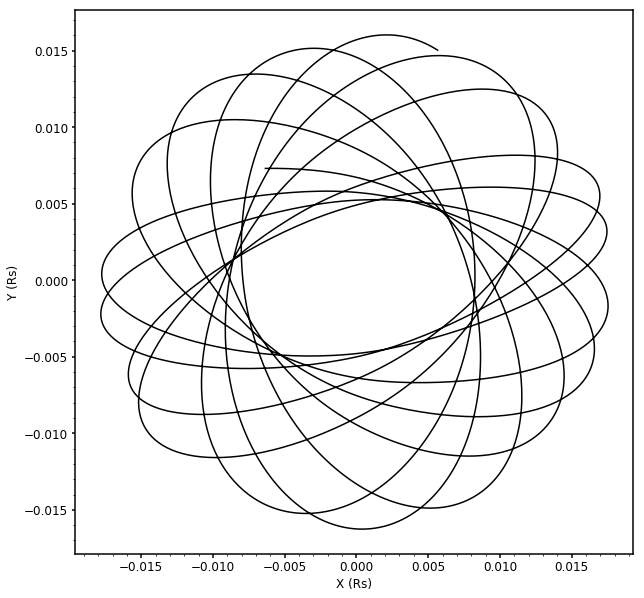

In [14]:
#lets plot our orbit!
plt.figure(figsize=(10,10))
plt.plot(orb['X'], orb['Y'], c='k') 
plt.xlabel('X (Rs)') #x, y in scale length
plt.ylabel('Y (Rs)')

## below, we show you how to run a grid of orbits
note - this code takes forever to run so you probably want to run it as a job, not in a notebook


In [5]:
scale_length = 0.01
vcirc = 1.4 #this is approximately the circular velocity, 
#can estimate this from average vphi in a radial annulus
initpos = np.linspace(.02*scale_length,5*scale_length,128) #range of radii
initvel = np.linspace(-0.4,vcirc*1.2,100)  
#range of velocities, negative to a bit over circular velocity
intime = 556 #time that we want to freeze potential at
integrate.run_time_mod(sim_path,'run2Fb', #sim path and sim name
                 eof_file=sim_path+'eof.cache.fileF', #eof file path and name
                 sph_file = sim_path+'SLGridSph.cache.run2Fb', #sph path and name
                 model_file = sim_path + 'run100.model', #model file path and name
                 save_field = True, #do you want to save the field that you generate?
                 field_file_name = sim_path+'field_file'+str(intime), #if yes to above, what do you want to name the field file?
                 #note if you already have a field file, you should provide its name here!
                 field_file = None, #change to True if you already have a field file, give name of file in above line
                 bar_file = sim_path+'2Fb_m2n2_barpos.dat', #bar file that you generated in cell above!
                 intime=intime, #what start time?
                 rads=initpos,vels=initvel, #input grid of initial positions, velocities
                 nint=2500,#number of integration steps
                 dt=0.0003, #size of integration steps
                 no_odd=True, #if true, use only m = 0, 2, 4, 6 etc (skip odd modes)
                 halo_l=4,#number of azimuthal terms in halo (negative number just means use all)
                 max_m=6, #number of azimuthal terms in disk (negative number just means use all)
                 dyn_res=80,#minimum number of substeps to resolve (default: 100., likely overkill)
                 ap_max=80, #max number of aposes to compute
                 verbose=2, #verbosity level - what volume of printed messages do you want
                 nprocs=-1, #multiprocessing? negative number = yes
                 omegap=-1., #pattern speed if you want to give one that is different from bar file/field, 
                 #and -1 just uses what you get from field file 
                 orbitfile='/home/filion/martinsims/exptools/orbs_2', #name, directory for file where we save the orbits
                 transform=True, #transform to bar frame
                 fileprefix = 'OUT') #simulation output prefix - PSP is usually 'OUT', SPL is usually 'SPL'
#note that if you already have a field file, you can delete the save_field line, but you need
#to specify the name of the field file in field_file_name and set field_file to true
print('finished!')

exptool.integrate.run_time: in directory /usr/data/scylla/rmcclure/cca/sims/Run100/, run run2Fb at output 556, with transform=True
potential.Fields.total_coefficients: Computing centering (centering=True)
potential.Fields.total_coefficients: Using computed disk center for halo (mutual_center=True)
potential.Fields.total_coefficients: (x,y,z) = 0.00000,0.00012,0.00000
eof.make_coefficients_multi: 16 processors, 62500 particles each.
eof.make_coefficients_multi: Accumulation took 6.83 seconds, or 6.83 microseconds per orbit.
sl.compute_coefficients: 16 processors, 625000 particles each.
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000e-06  1.10290253e+07  1.18700000e-12 -8.99051397e+00]
[ 1.00730000

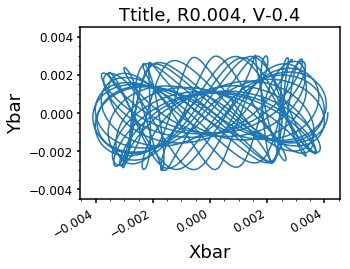

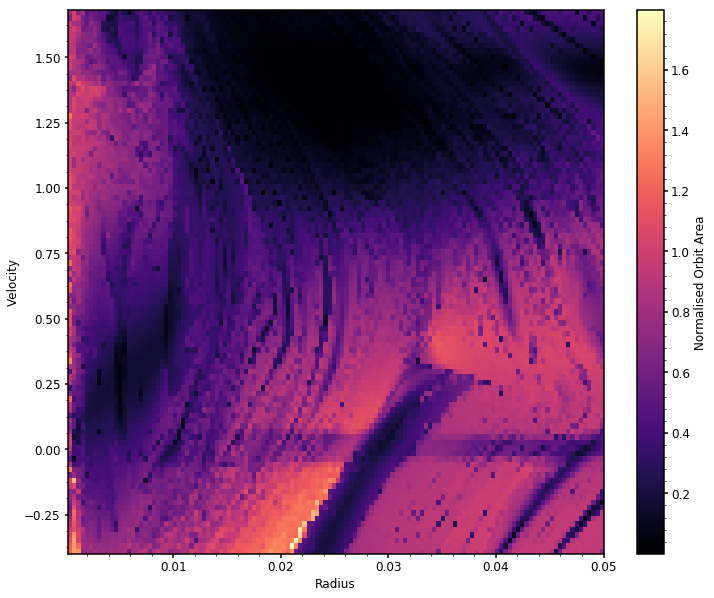

In [8]:
#if you want to make an orbit-area diagram
from exptool.analysis import commensurability
D = commensurability.read_integrations('/home/filion/martinsims/exptools/orbs_2') #read in the orbit file made above
#plot a single orbit:
commensurability.make_orbit_plot(D,
        num = 1000, #index of star that you want to plot the orbit of
        outdir='/home/filion/martinsims/', #directory where you want plot to go
                T='title') #plot title
#calculate the orbit areas for orbit area diagram -
Aarr = commensurability.calculate_area_array(D,
        ratio=10.) #ratio of minimum side length to maximum to not count toward the area total


#make orbit area plot!
initpos = np.linspace(.02*scale_length,5*scale_length,128) #range of radii
initvel = np.linspace(-0.4,vcirc*1.2,100)  
commensurability.plot_orbit_areas(Aarr, #area array
                initpos, initvel, #initial position and velocity arrays from above
                cmap='magma',  #cmap
                savestring='orbit_area_plot.jpeg') #file name for saving